Fastai vision on iWildCam 2020 data resized to 256x256.
Resnet50 + mixup + TTA

## Data pre-processing

In [1]:
import os

import pandas as pd
from matplotlib import pyplot as plt

from fastai import *
from fastai.vision import *

import json

%matplotlib inline

Read in training dataset.

In [2]:
test_images = os.listdir("../input/iwildcam2020-256/256_images/test/images/")
train_images = os.listdir("../input/iwildcam2020-256/256_images/train/images/")

In [3]:
with open(r'/kaggle/input/iwildcam-2020-fgvc7/iwildcam2020_train_annotations.json') as json_file:
    train_data = json.load(json_file)

In [4]:
df_train = pd.DataFrame({'id': [item['id'] for item in train_data['annotations']],
                         'category_id': [item['category_id'] for item in train_data['annotations']],
                         'image_id': [item['image_id'] for item in train_data['annotations']],
                         'location': [item['location'] for item in train_data['images']],
                         'file_name': [item['file_name'] for item in train_data['images']]})

df_train.head()

,id,category_id,image_id,location,file_name
0,a292dd3c-21bc-11ea-a13a-137349068a90,73,96b00332-21bc-11ea-a13a-137349068a90,267,96b00332-21bc-11ea-a13a-137349068a90.jpg
1,a0afcfc0-21bc-11ea-a13a-137349068a90,4,879d74d8-21bc-11ea-a13a-137349068a90,264,879d74d8-21bc-11ea-a13a-137349068a90.jpg
2,a306e9c0-21bc-11ea-a13a-137349068a90,227,9017f7aa-21bc-11ea-a13a-137349068a90,45,9017f7aa-21bc-11ea-a13a-137349068a90.jpg
3,9eed94c4-21bc-11ea-a13a-137349068a90,250,90d93c58-21bc-11ea-a13a-137349068a90,45,90d93c58-21bc-11ea-a13a-137349068a90.jpg
4,a2a4dd7a-21bc-11ea-a13a-137349068a90,2,887cd0ec-21bc-11ea-a13a-137349068a90,45,887cd0ec-21bc-11ea-a13a-137349068a90.jpg


In [5]:
df_train.shape

(217959, 5)

In [6]:
df_train = df_train[df_train['file_name'].isin(train_images)]

In [7]:
df_train.shape

(217953, 5)

Split training validation using categories. 70% of category entries in training set.

In [8]:
cat_images = dict()
cat_count = dict()

annotations = train_data['annotations']
_images = train_data['images']
for i, annotation in enumerate(annotations):
    _img = annotation['image_id']
    cat = annotation['category_id']
    
    imgs = cat_images.get(cat, None)
    if imgs is None:
        cat_images[cat] = [{'image_id': _img, 'category': cat}]
    else:
        cat_images[cat].append({'image_id': _img, 'category': cat})
        
    count = cat_count.get(cat, 0)
    if count == 0:
        cat_count[cat] = 1
    else:
        cat_count[cat] += 1
        
n_train = dict()
n_val = dict()

for cat, count in cat_count.items():
    _train = math.floor(count * 0.70)
    if _train < 1:
        _train = 1
    _val = count - _train
    n_train[cat] = _train
    n_val[cat] = _val

train_images = []
val_images = []
for cat in cat_images.keys():
    random.shuffle(cat_images[cat])
    train_images += cat_images[cat][:n_train[cat]]
    val_images += cat_images[cat][n_train[cat]:]

val_img_dt = pd.DataFrame(val_images)



Tag validation set.

In [9]:
df_train['is_valid'] = np.where(df_train.image_id.isin(val_img_dt['image_id']), True, False)

Check what is location split.

In [10]:
loc_valid = df_train.loc[(df_train['is_valid'] == True)].location.unique()
loc_train = df_train.loc[(df_train['is_valid'] == False)].location.unique()

loc_valid.shape
df_train.category_id.unique().shape

(216,)

In [11]:
df_train.groupby('is_valid').size()

is_valid
False    152495
True      65458
dtype: int64

Remove corrupted images.

In [12]:
df_train.drop(df_train.loc[df_train['file_name']=='87022118-21bc-11ea-a13a-137349068a90.jpg'].index, inplace=True)
df_train.drop(df_train.loc[df_train['file_name']=='8792549a-21bc-11ea-a13a-137349068a90.jpg'].index, inplace=True)

In [13]:
df_train.category_id.unique().shape

(216,)

Read test data.

In [14]:
with open(r'/kaggle/input/iwildcam-2020-fgvc7/iwildcam2020_test_information.json') as f:
    test_data = json.load(f)

In [15]:
df_test = pd.DataFrame.from_records(test_data['images'])
df_test.head()

,seq_num_frames,location,datetime,id,frame_num,seq_id,width,height,file_name
0,1,84,2013-08-02 21:44:00.000,88037cce-21bc-11ea-a13a-137349068a90,1,88037e90-21bc-11ea-a13a-137349068a90,2771,1779,88037cce-21bc-11ea-a13a-137349068a90.jpg
1,1,84,2013-08-02 21:51:00.000,963e6b46-21bc-11ea-a13a-137349068a90,1,963e6cb8-21bc-11ea-a13a-137349068a90,2771,1779,963e6b46-21bc-11ea-a13a-137349068a90.jpg
2,1,548,2013-04-25 18:23:00.000,8a1b53ba-21bc-11ea-a13a-137349068a90,1,8a1b5554-21bc-11ea-a13a-137349068a90,2895,1865,8a1b53ba-21bc-11ea-a13a-137349068a90.jpg
3,1,181,2013-04-17 16:10:00.000,938c0d5e-21bc-11ea-a13a-137349068a90,1,938c0f02-21bc-11ea-a13a-137349068a90,2902,1818,938c0d5e-21bc-11ea-a13a-137349068a90.jpg
4,1,181,2013-04-20 03:11:00.000,95b9bd92-21bc-11ea-a13a-137349068a90,1,95b9be96-21bc-11ea-a13a-137349068a90,2212,1841,95b9bd92-21bc-11ea-a13a-137349068a90.jpg


## Modelling part

I'm creating a ImageDataBunch in a few steps. DataBunch is an object that the model needs.
First I create an `ImageList` with training and test data.
Secondly I define the transformations that will be applied to the pictures.
I say that labels for the training come from the dataframe and are stored in `category_id` column. I add the test set.
Finally I can create the databunch. Apply transofrmations to the data, resize all pictures to 128x128, add reflection padding. I want to use a batch size `bs` of 256 images, and normalize the data with `imagenet_stats`.

In [16]:
train, test = [ImageList.from_df(df, path='../input/iwildcam2020-256/256_images/', cols='file_name', folder=folder, suffix='') 
               for df, folder in zip([df_train, df_test], ['train/images', 'test/images'])]
trfm = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)
src = (train.use_partial_data(1)
        .split_from_df(col='is_valid')
        .label_from_df(cols='category_id')
        .add_test(test))
data = (src.transform(trfm, size = 128, padding_mode = 'reflection')
        .databunch(path=Path('.'), bs = 256).normalize(imagenet_stats))

In [17]:
print(data.classes)

[0, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 20, 24, 25, 26, 32, 44, 50, 62, 67, 70, 71, 72, 73, 74, 77, 78, 79, 80, 83, 86, 89, 90, 91, 92, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 108, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 127, 129, 130, 133, 134, 137, 139, 141, 142, 144, 145, 147, 150, 152, 153, 154, 156, 159, 161, 162, 163, 166, 167, 170, 175, 177, 198, 221, 227, 229, 230, 233, 234, 235, 240, 242, 243, 245, 250, 251, 252, 253, 256, 257, 258, 259, 262, 265, 267, 268, 273, 286, 290, 291, 292, 294, 296, 299, 300, 301, 302, 306, 307, 309, 310, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 330, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 344, 345, 346, 347, 348, 349, 350, 352, 353, 354, 355, 356, 357, 370, 371, 372, 374, 375, 376, 377, 378, 379, 380, 382, 384, 385, 389, 390, 391, 402, 404, 405, 406, 407, 408, 409, 410, 412, 413, 414, 415, 416, 417, 418, 419, 420, 422, 454, 558, 559, 561, 562, 563, 564, 565, 

In [18]:
org_classes = pd.DataFrame({"org_category": data.classes})
org_classes['Category'] = org_classes.index

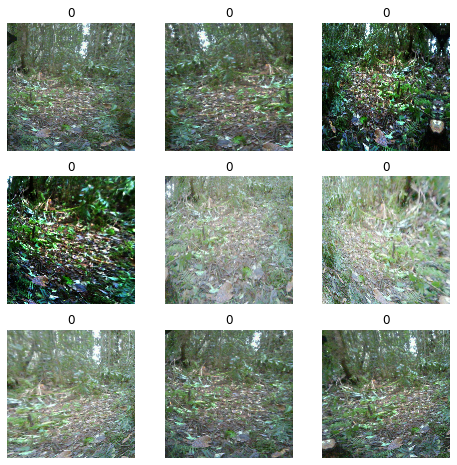

In [19]:
def _plot(i,j,ax):
    x,y = data.train_ds[1]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

Show batch.

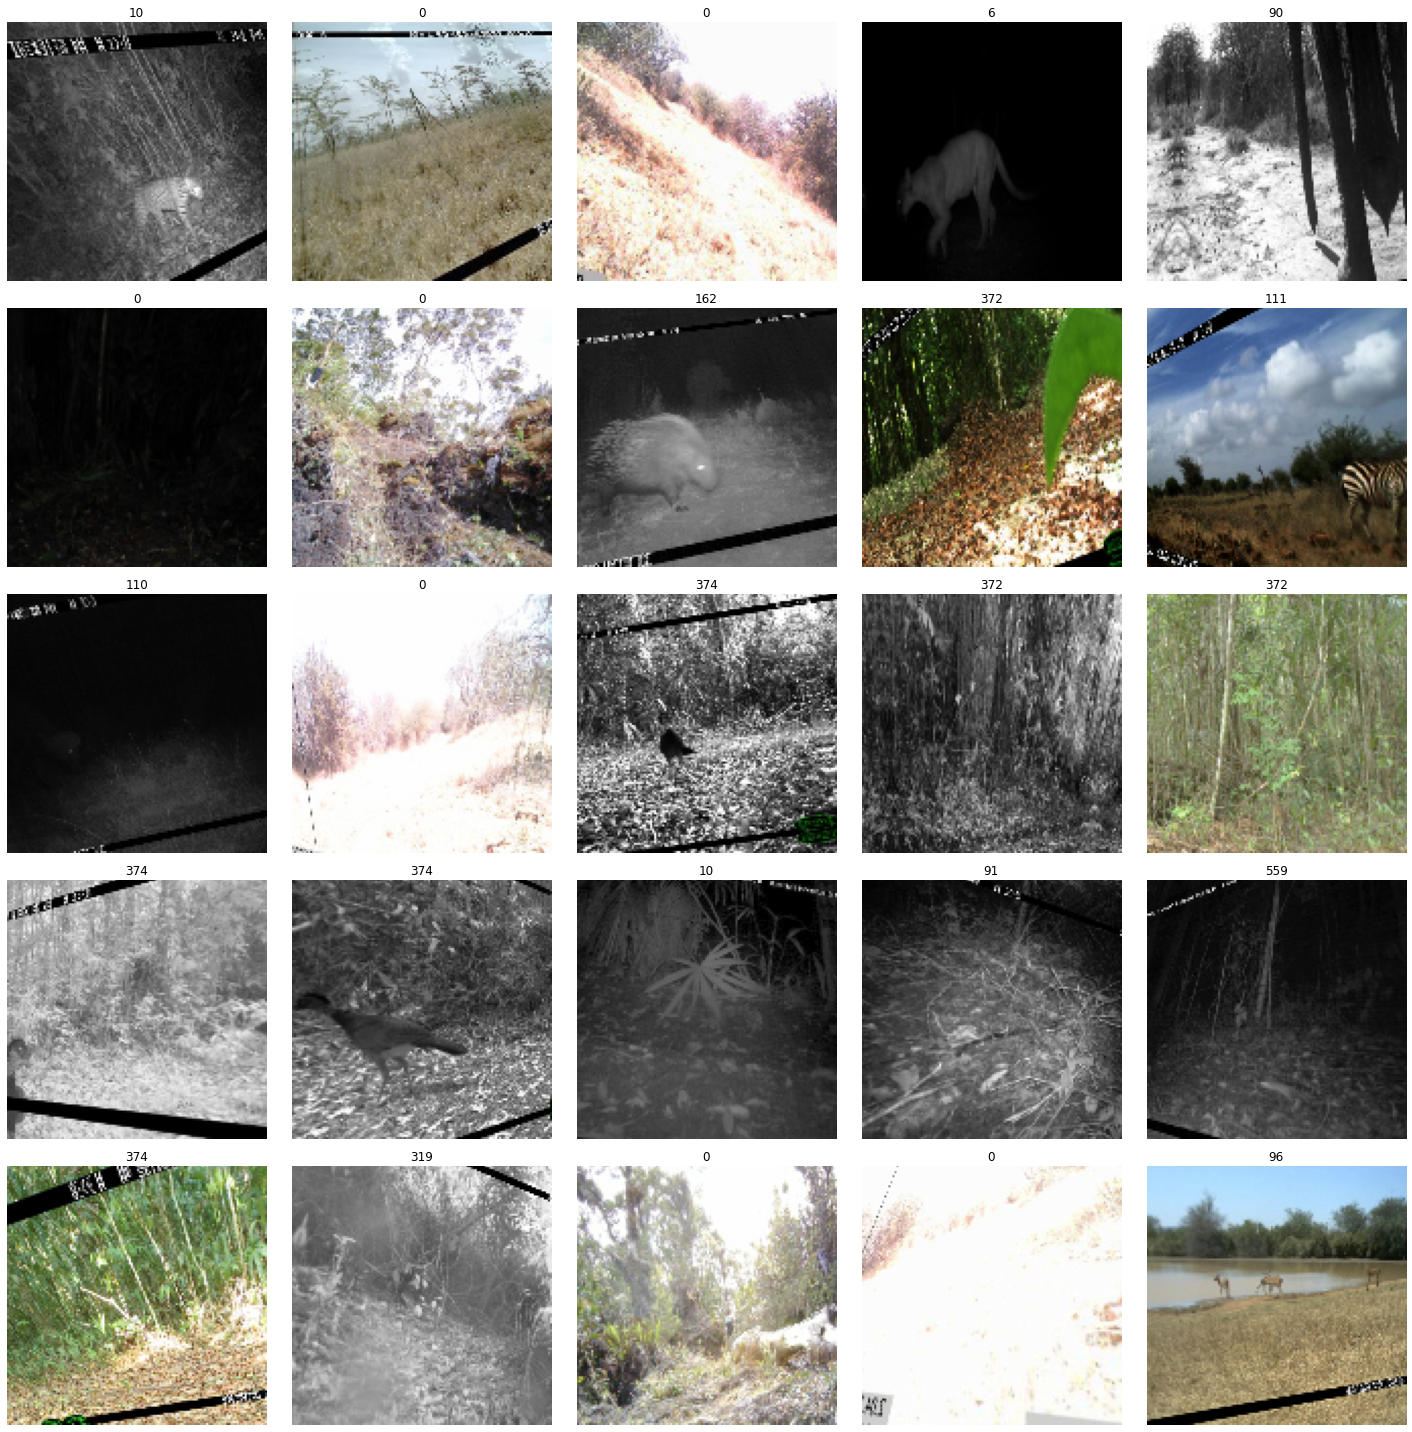

In [20]:
data.show_batch()

Show number of categories in the data.

In [21]:
data.c

216

I use transfer learning. This means I will use a pre-trained model in this case Resnet50 and adapt it to my dataset. In transfer learning we keep the convolutionals layers: body or the backbone with their weigths pre-trained on ImageNet and only define a new head. I use the head defined by the fastai library.

I use accuracy as the metric to print. I add mixup. Model won't be trained on actual photos, but on random combinations of them.

In [22]:
learn = cnn_learner(data, base_arch=models.resnet50, metrics=accuracy).mixup()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


The most important parameter to set is learning rate which is the step size in the optimization to reach the loss minimum. To find the learning rate I use `lr_find`. What it does is it starts with a very small lr, increases it with every batch and records the loss. Then the lr values are ploted against the losses.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03
Min loss divided by 10: 2.09E-02


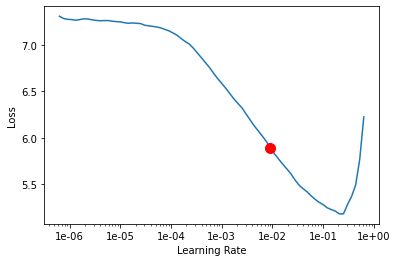

In [23]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

Recommended methods choosing the LR:
 * at the steepest decline of loss
 * 10x prior to the minimum loss. 

In [24]:
learn.recorder.min_grad_lr

0.009120108393559097

Fastai.vision module divides the architecture in 3 groups and trains them with variable learning rates depending on what you input. (Starting layers usually don't require large variations in parameters)

Additionally, if you use 'fit_one_cycle', all the groups will have learning rate annealing with their respective variable learning.
First I freeze the body weights and only train the head.

In [25]:
learn.fit_one_cycle(10, slice(0.01))

epoch,train_loss,valid_loss,accuracy,time
0,2.177886,1.398428,0.643145,18:39
1,1.924697,1.179692,0.680971,18:39
2,1.797551,1.031726,0.722708,17:17
3,1.704796,0.929734,0.749213,17:14
4,1.673721,0.877335,0.757845,17:16
5,1.605819,0.815304,0.774542,17:18
6,1.585908,0.763771,0.788719,17:24
7,1.552677,0.731124,0.795991,17:31
8,1.508904,0.710079,0.801705,17:23
9,1.523997,0.705168,0.802515,16:32


After the random weights in the head are trained a bit, we can unfreeze the weights in the whole network and train everything.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 3.31E-07


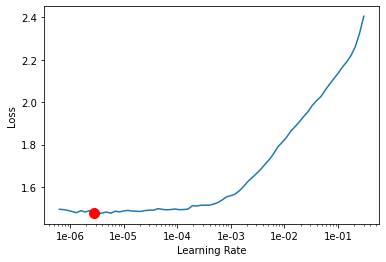

In [26]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [27]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.500554,0.692336,0.806196,15:20
1,1.475733,0.666763,0.814431,15:03
2,1.441541,0.630393,0.821855,15:03
3,1.417242,0.595367,0.833160,14:59
4,1.368896,0.550399,0.842815,15:01
5,1.324874,0.523636,0.850179,15:01
6,1.308151,0.500289,0.857328,16:19
7,1.283757,0.481500,0.862141,17:22
8,1.277951,0.472786,0.865181,17:44
9,1.277892,0.471619,0.864967,17:19


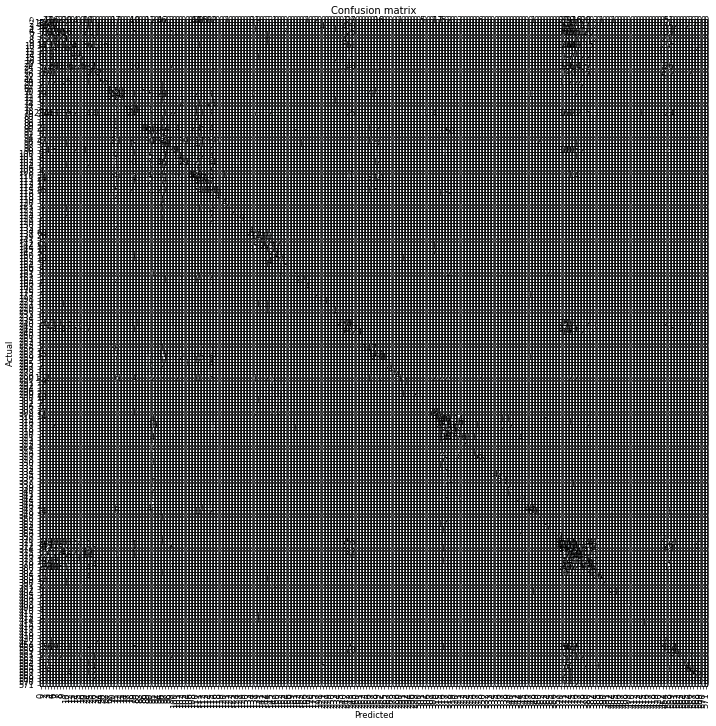

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Make predictions on the test set using test time augmentation. TTA makes 4 predictions using the transforms of the training set and averages them. 

In [29]:
preds,y = learn.TTA(ds_type=DatasetType.Test)

In [30]:
pred_csv = pd.DataFrame(preds.numpy())
pred_csv['Id'] = learn.data.test_ds.items
pred_csv.to_csv("outout_preds.csv", index = False)

In [31]:
submission = pd.read_csv('../input/iwildcam-2020-fgvc7/sample_submission.csv')
id_list = list(submission.Id)
pred_list = list(np.argmax(preds.numpy(), axis=1))
pred_dict = dict((key, value.item()) for (key, value) in zip(learn.data.test_ds.items,pred_list))
pred_ordered = [pred_dict['../input/iwildcam2020-256/256_images/test/images/' + id + '.jpg'] for id in id_list]
submission_with_idx = pd.DataFrame({'Id':id_list,'Category':pred_ordered})
submission_fixed_labels = pd.merge(submission_with_idx, org_classes, on = 'Category', how='left')
submission_fixed_labels = submission_fixed_labels.drop(['Category'], axis = 1)
submission_fixed_labels.rename(columns={'org_category': 'Category'}, inplace=True)

submission_fixed_labels.to_csv("submission.csv".format(Category),index = False)
print("Done")

Done
